**Download do dataset original:**
https://www.kaggle.com/luisfredgs/imdb-ptbr/kernels

**Dados usados nesse tutorial:**
https://drive.google.com/drive/folders/1hwhqN-CUIGGZZXpVnka08yaItZsMQapx?usp=sharing




# Processamento e análise dos dados


In [0]:
# Preparando ambiente (importando bibliotecas e downloads...)

!pip install nltk
import nltk
nltk.download('rslp')
nltk.download('stopwords')
nltk.download('punkt')
import re
import pandas as pd 

In [0]:
# Importando dataset
df = pd.read_csv("dataset.csv", sep="," , encoding="utf8")

In [0]:
# Separacao dos dados por sentimento
df.groupby('sentiment').count()

,id,text_en,text_pt
sentiment,,,
neg,1999,1999,1999
pos,1960,1960,1960


### Removendo e tratando dados

In [0]:
# Remove columns e create column
df.drop(columns=['id', 'text_en'], axis=1, inplace=True)
df['classification'] = df["sentiment"].replace(["neg", "pos"],[0, 1])

# Texto para minusculo
text_lower = [t.lower() for t in df['text_pt']]
df['text_pt'] = text_lower

df.head(5)

,text_pt,sentiment,classification
0,"mais uma vez, o sr. costner arrumou um filme p...",neg,0
1,este é um exemplo do motivo pelo qual a maiori...,neg,0
2,"primeiro de tudo eu odeio esses raps imbecis, ...",neg,0
3,nem mesmo os beatles puderam escrever músicas ...,neg,0
4,filmes de fotos de latão não é uma palavra apr...,neg,0


In [0]:
# funcao para remover brackets
def remove_brackets(column):
    for x in range(1,len(column)):
        return(re.sub('[\[\]]','',repr(column)))

### Stemmer e stopwords

In [0]:
%%time

from nltk.tokenize import word_tokenize 
stop_words = nltk.corpus.stopwords.words('portuguese')
stemmer = nltk.stem.RSLPStemmer()

# Trabalhar com stemmer e stopwords da base de treinamento/teste

for x in range(0,len(df['text_pt'])):

    # Remover as stop words do texto
    word_tokens = word_tokenize(df['text_pt'][x]) 
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    
    # Remover sufixos 
    line=[]
    text_tokenized = word_tokenize((remove_brackets(filtered_sentence)))
    line =  [stemmer.stem(word) for word in text_tokenized]
    df['text_pt'][x] = (remove_brackets(line))



CPU times: user 7min 44s, sys: 139 ms, total: 7min 44s
Wall time: 7min 44s


In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

# Regex para remover alguns valores do dataset  (simbolos, numeros...)
token = RegexpTokenizer(r'[a-zA-Z0-9]+')

# Cria o 'vetorizador' de acordo com os parametros abaixo
cv = CountVectorizer(lowercase=True,stop_words=None,ngram_range = (1,2),
                     tokenizer = token.tokenize)

# Matrixsparse da representação da coluna  text_pt
text_counts= cv.fit_transform(df['text_pt'])


In [0]:
# Vocabulario
cv.vocabulary_

# Testando o modelo 

In [79]:
# Importando biliotecas para selecao de amostra, modelo e avaliação do modelo.
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# Divindo no dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(text_counts, df['classification'], 
                                                    test_size=0.34, random_state=1, 
                                                    shuffle=True)
# Criar modelo e treinar
clf = MultinomialNB().fit(X_train, y_train)

# Fazendo  predict do valor de X para teste de acuracidade
y_predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, y_predicted).round(3))

MultinomialNB Accuracy: 0.912


### Recebendo dados do texto (txt) para gerar grafíco

In [0]:
# Separa por paragrafos 
with open('./texto_teste.txt', 'r') as file_teste:
    paragraph = file_teste.read().split('\n\n')

# Separa por frases
with open('./texto_teste.txt', 'r') as file_teste:
    phrase = file_teste.read().split('.')


### Fazer stemmer e stopwords do conteúdo do texto

In [0]:
#Importar stemmer novamente
stemmer = nltk.stem.RSLPStemmer()

# Criar dataframe
df_result = pd.DataFrame()


# Fazer a tokanização, remocao de stop words e 
# transformar os dados para predict
neg,pos=0,0
for x in range(0,len(phrase)-1):

    # Texto tokenizado
    text_tokenized = word_tokenize(phrase[x])

    # Remove stop words do texto
    filtered_sentence = [w for w in text_tokenized if not w in stop_words] 

    # Cria stemmer do texto input
    line =  [stemmer.stem(word) for word in filtered_sentence]
    line = (remove_brackets(line))

    # Criar prediction para cada frase
    value_trans = cv.transform([line])
    predict_phrase = clf.predict(value_trans)

    # Contar por tipo de prediction (positivo e negativo)
    if predict_phrase==0:pos+=1
    else:neg+=1

# Salvar valores no dataframe
df_result['positive'] = [pos]
df_result['negative'] = [neg]


CPU times: user 135 ms, sys: 0 ns, total: 135 ms
Wall time: 135 ms


# Criando gráfico de análise de sentimento 

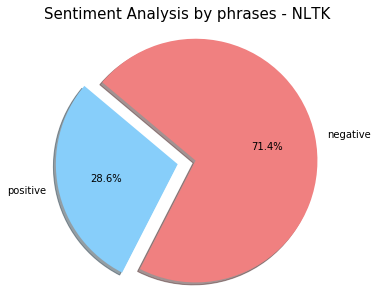

Quantity by paragraph: 9
Quantity by phrases: 28
Quantity by positives phrases: 8
Quantity by negatives phrases: 20


In [80]:
def generate_piechart(df_result):
    
    import matplotlib.pyplot as plt
    labels = df_result.columns.tolist()
    sizes = df_result.values.tolist()[0]
    color = ['lightskyblue', 'lightcoral']
    explode = (0.15, 0)

    fig1, ax1 = plt.subplots(figsize=(5,5))
    ax1.pie(sizes, labels=labels,  explode=explode,
            shadow=True, autopct='%1.1f%%',  startangle=140, colors=color)

    ax1.set_title('Sentiment Analysis by phrases - NLTK', fontsize=15)

    ax1.axis('equal')
    plt.show()
    print("Quantity by paragraph: {}".format(len(paragraph)))
    print("Quantity by phrases: {}".format(len(phrase)-1))
    print("Quantity by positives phrases: {}".format(df_result['positive']
                                                     .values.tolist()[0]))
    
    print("Quantity by negatives phrases: {}".format(df_result['negative']
                                                     .values.tolist()[0]))
    
# Gerar gráfico    
generate_piechart(df_result)